In [ ]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import importlib

import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
#%matplotlib widget

from tqdm import tqdm
import io, sys
from contextlib import redirect_stdout, redirect_stderr

import os

import h5py
import hdf5plugin

import sys
sys.path.append('./XPCS_library/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

# RAW FOLDER PATH
raw_folder = '../RAW_DATA/'
masks_folder = '../masks/'
fit_outs_folder = './data/fit_outs/'
Idts_folder = './data/Idts/'
g2_folder = './data/g2/'

# EXPERIMENTAL VARIABLES
XPCS.set_expvar(1350, 1350, 7)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

## Load masks

In [2]:
e4m_htmask = np.load(masks_folder+'e4m_htmask_copper_foil_30um_1_1'+'.npy')
e4m_mask = np.load(masks_folder+'e4m_mask'+'.npy')
#bs_mask = np.load(masks_folder+'bs_mask_copper_foil_30um'+'.npy')  # beam-stop mask

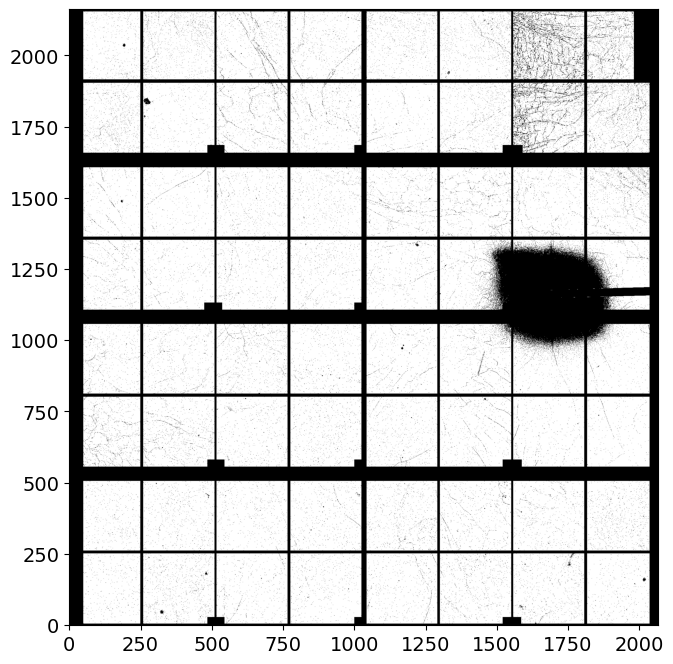

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')

### BS mask and Q definition
Using a random scan in GeO2_6, because we are not changing the measurement configuration

#### Beamstop mask

In [4]:
#######################################
sample_name = 'GeO2_6'
Ndataset = 1
Nscan =12
Nfi, Nff = 0, 1000
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

#############################
command = mtimescan 0.02 1 220000
Ei = 9.699998837562536
itime = 0.0201
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/1 loops)
Done!
Concatenating vectors ...
Done!
	 | Sparse array loaded from ../RAW_DATA/GeO2_6/GeO2_6_0001/scan0012/
	 | Shape:       (1000, 4471016)
	 | Sparsity:     3.8e-03
	 | Memory usage (scipy.csr_array): 0.192 GB (np.array usage: 16.656 GB)


################################################################################
Maximum count in the hull run -> 4689
# of pixels above Ith_high treshold ->  75 pixels (of 4471016 => 0.0 %)
################################################################################



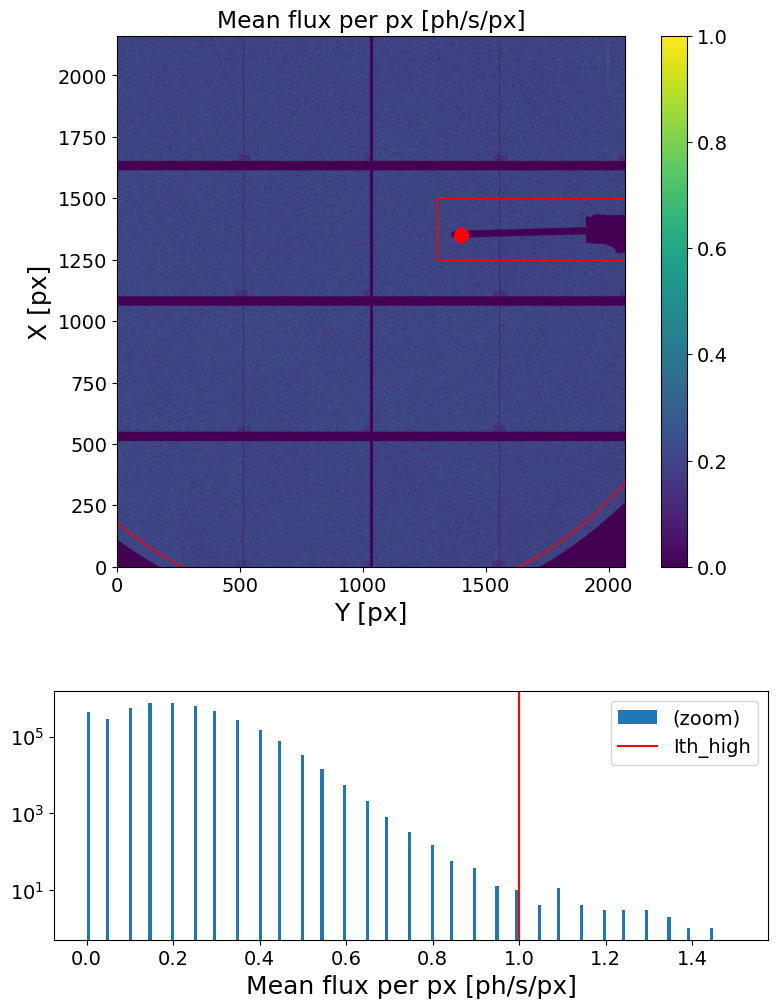

In [5]:
geom = [{'geom':'Rectangle', 'x0':1250, 'y0':1300, 'xl':250, 'yl':1950, 'inside':False},
        {'geom':'Circle', 'Cx':1300, 'Cy':950, 'r':1470, 'inside':True}, 
        ]
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, Nff=10000, mask_geom=geom,)

#################################################
Masked area =  93.74594052000708 %
#################################################



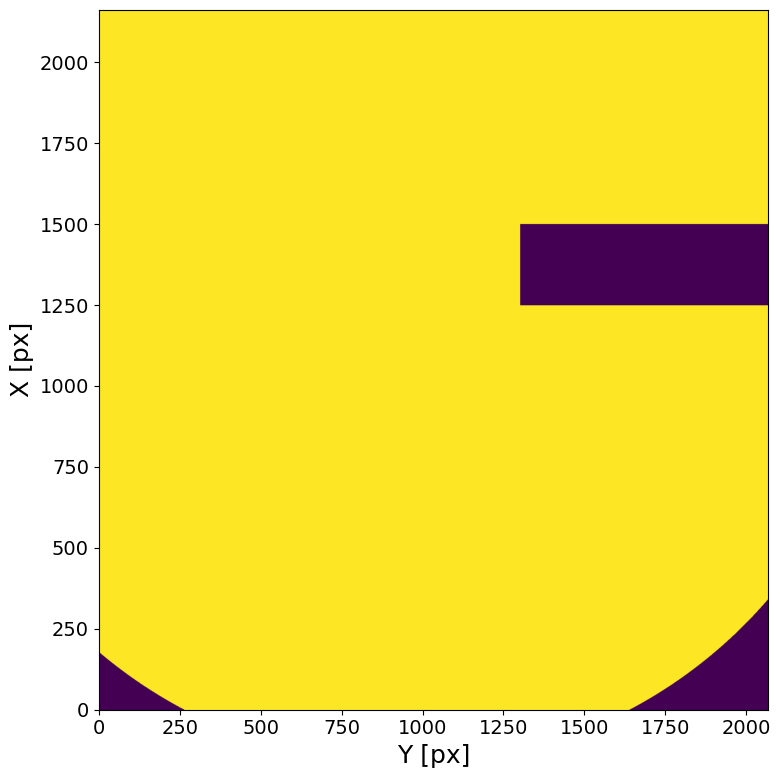

In [6]:
bs_mask = XPCS.gen_mask(e4m_data, itime, e4m_mask=None, mask_geom=geom)

#### Q mask

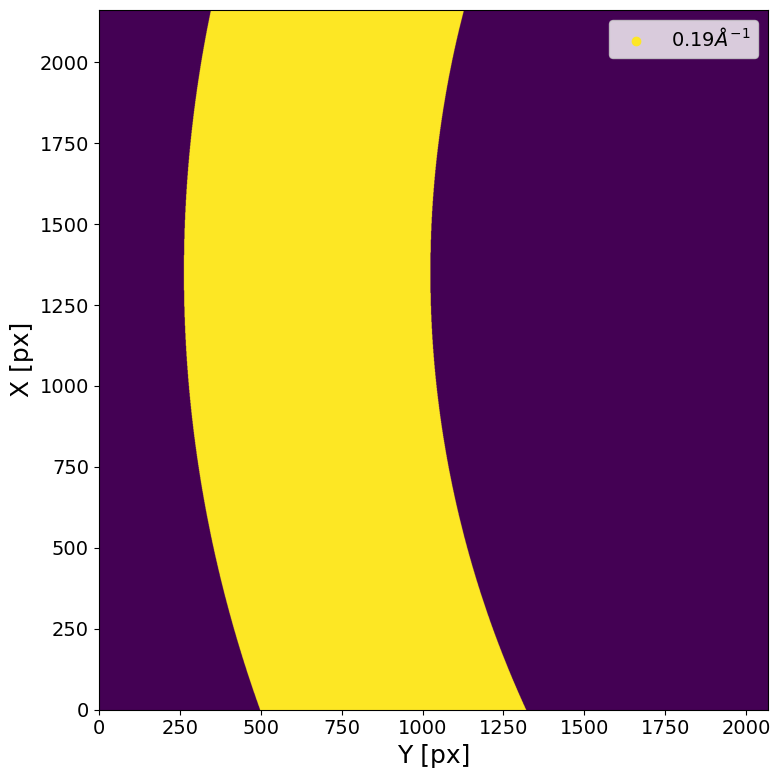

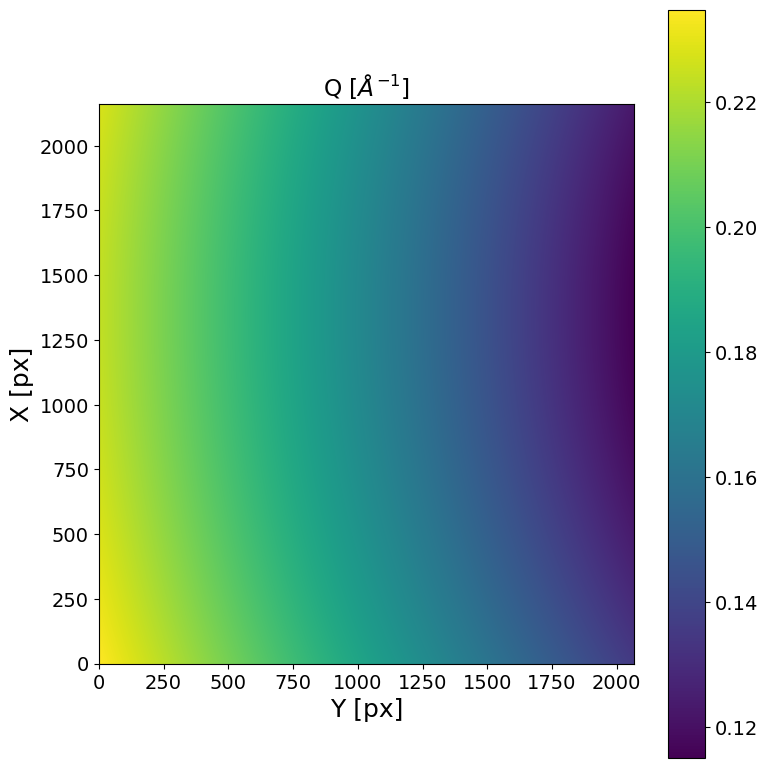

In [7]:
Qmask = XPCS.gen_Qmask(Ei, theta, .19, .02, Qmap_plot=True)

## XPCS mesh (T = 730C Q =  0.13 Å, 30 min @ 1ms (1_800_000 fm)) (GeO2_3, dataset 1, scan 4)

In [136]:
#######################################
sample_name = 'GeO2_3_730C_Q'
Ndataset = 1
Nscan = 4
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.0000000000000004
Q = 0.09
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/361 loop

### Qmask

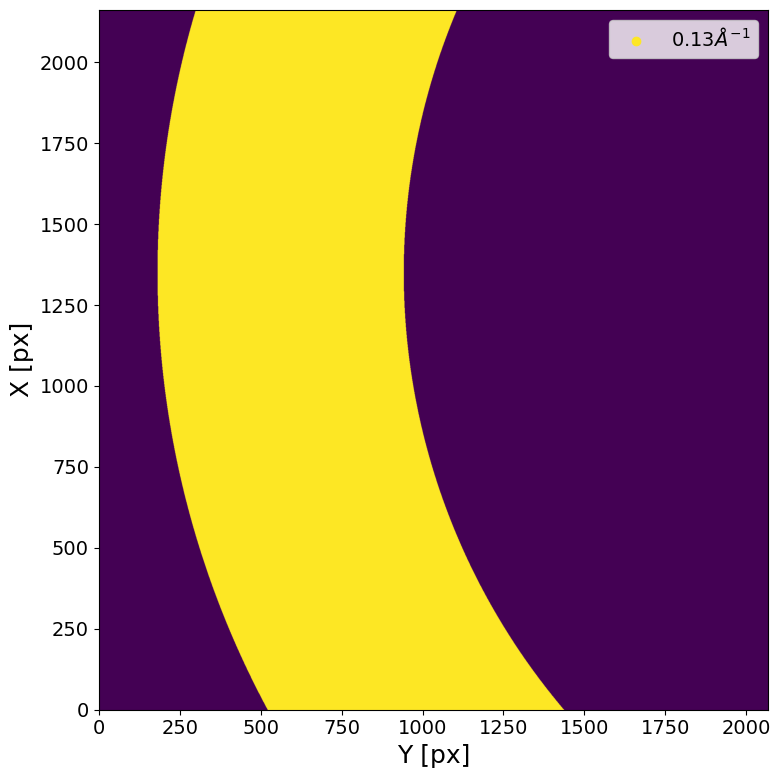

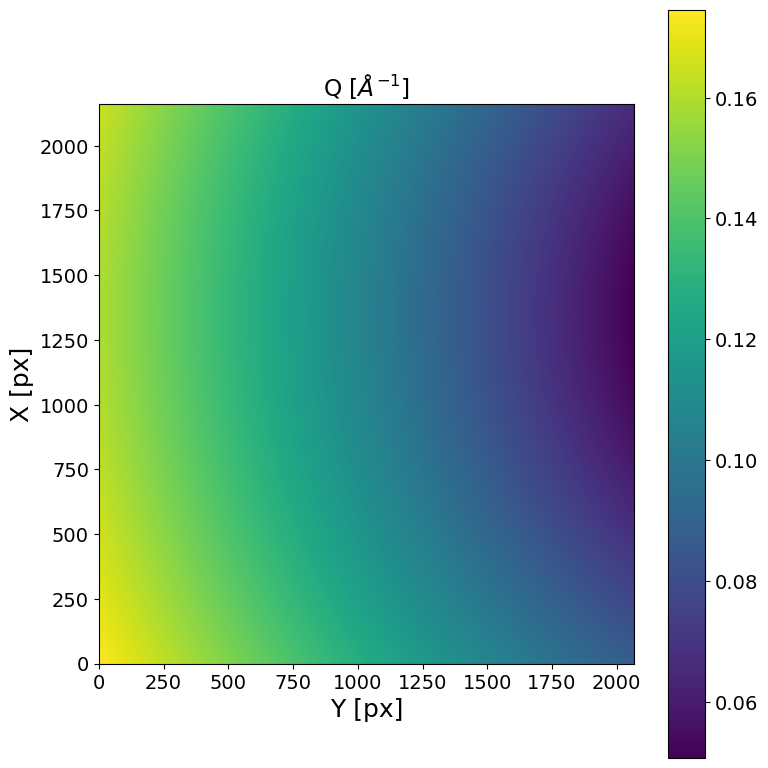

In [137]:
###################
Q    = .13
Qres = .02
###################

Qmask = XPCS.gen_Qmask(Ei, theta, Q, Qres, Qmap_plot=True)

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  54 pixels (of 4471016 => 0.0 %)
################################################################################



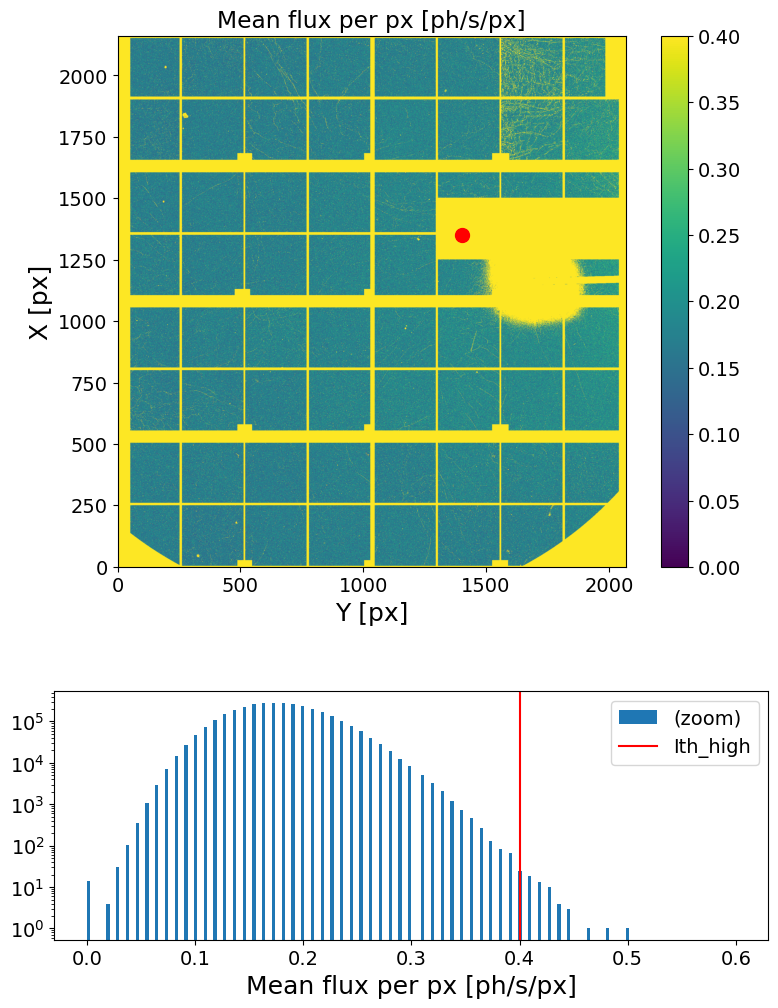

In [138]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .4, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [139]:
####################
Lbin = 1
Nstep = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

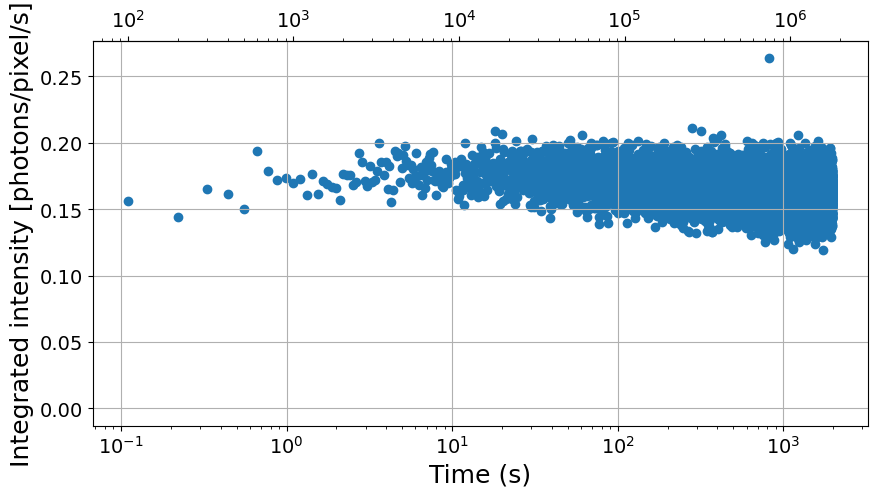

In [140]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [141]:
###################
Nfi = 100_000
Nff = None
Lbin = 1
Nbunch = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t_bybunch(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, Nbunch=Nbunch)

Computing G2t for bunch 1 (Nfi = 100000 , Nff = 117002 ) ...
Loading frames ...
Done! (elapsed time = 0.1 s)
	 | 17002 frames X 4471016 pixels
	 | sparsity = 1.77e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.113 GB
Masking data ...
Done! (elapsed time = 0.53 s)
	 | 17002 frames X 1461854 pixels
	 | sparsity = 1.87e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.039 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 1.19 s)
	 | 17002 X 17002 squared matrix
	 | memory usage (np.array @ float64) = 2.154 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.95 s)

Done!

Computing G2t for bunch 2 (Nfi = 117002 , Nff = 134004 ) ...
Loading frames ...
Done! (elapsed time = 0.18 s)
	 | 17002 frames X 4471016 pixels
	 | sparsity = 1.77e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.113 GB
Masking data ...
Done! (elapsed time = 0.59 s)
	 | 17002 frames X 1461854 pixels
	 | sparsity = 1.86e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.039 GB
Compu

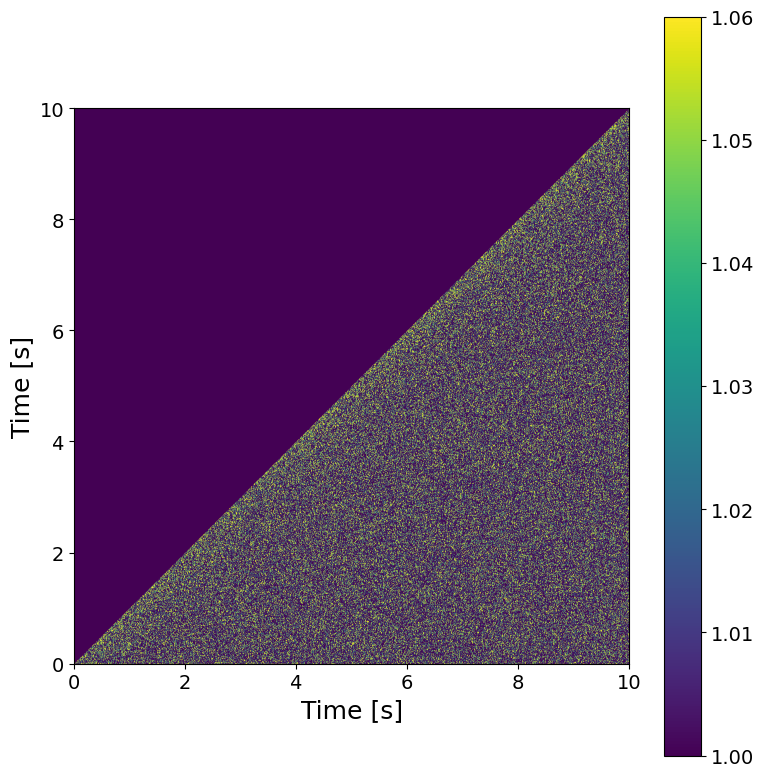

In [145]:
############################
t1, t2 = 0, 10
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

### g2(t)

In [146]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 0.28 s)



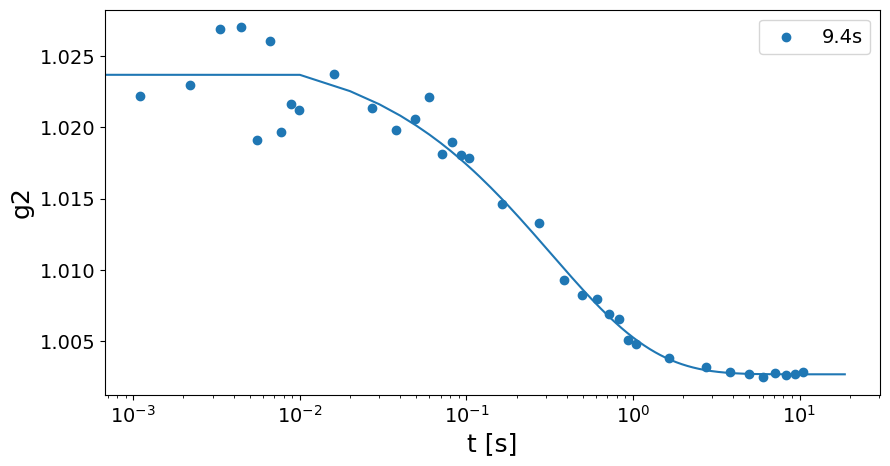

tau = 0.32165541720269253 +/- 0.07017522359662673
beta = 0.6891727572614254 +/- 0.09711502190975027
c = 0.023033930025721263 +/- 0.0027398033991368337
y0 = 1.002671829658822 +/- 9.057884837924134e-05


In [147]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

fit_out.to_csv(fit_outs_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  

## XPCS mesh (T = 730C Q =  0.29 Å, 30 min @ 1ms (1_800_000 fm)) (GeO2_3, dataset 1, scan 5)

In [114]:
#######################################
sample_name = 'GeO2_3_730C_Q'
Ndataset = 1
Nscan = 5
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 3.0000000000000004
Q = 0.26
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/361 loop

### Qmask

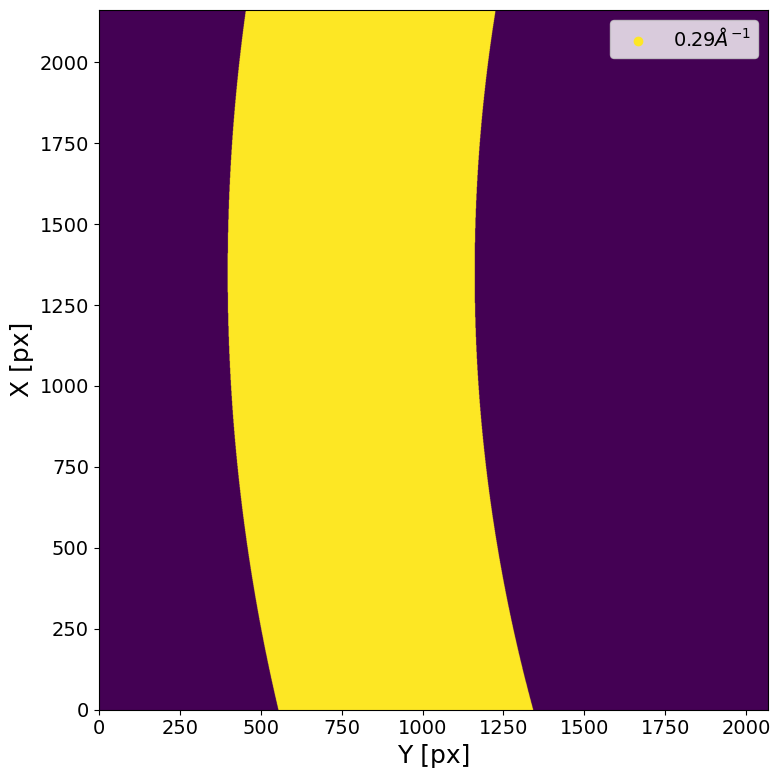

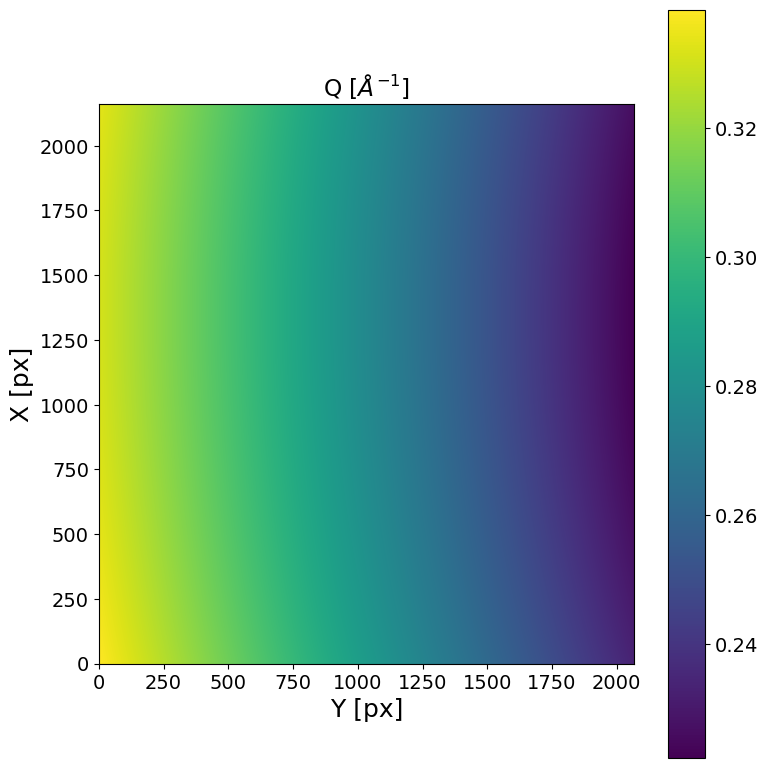

In [115]:
###################
Q    = .29
Qres = .02
###################

Qmask = XPCS.gen_Qmask(Ei, theta, Q, Qres, Qmap_plot=True)

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  14 pixels (of 4471016 => 0.0 %)
################################################################################



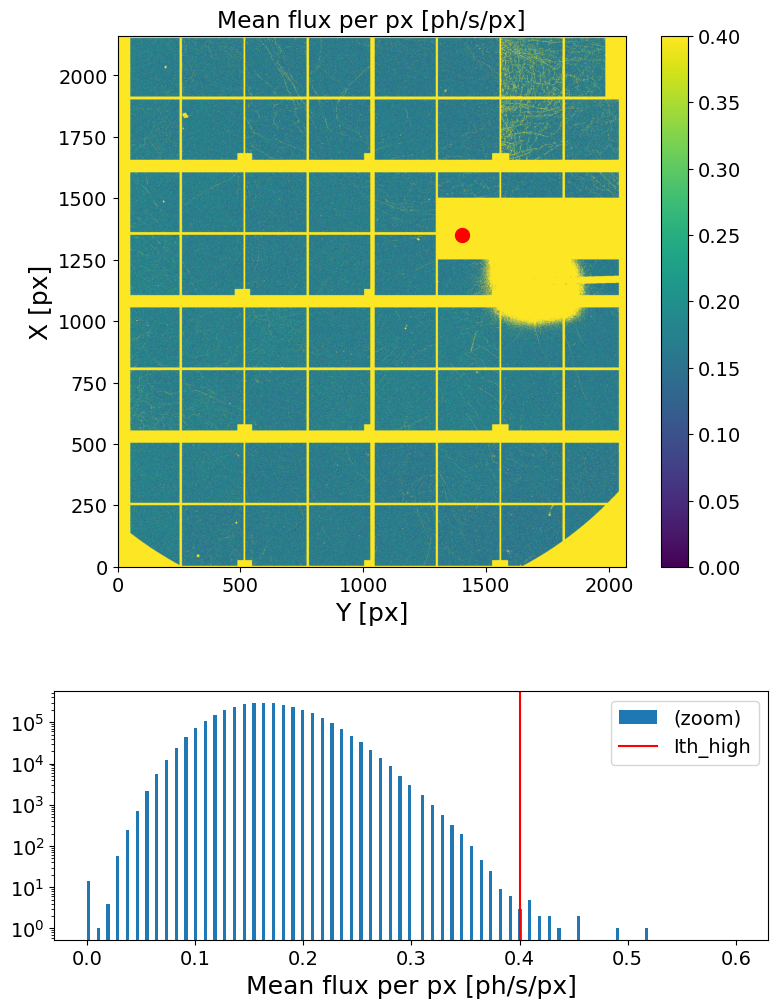

In [116]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .4, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [117]:
####################
Lbin = 1
Nstep = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

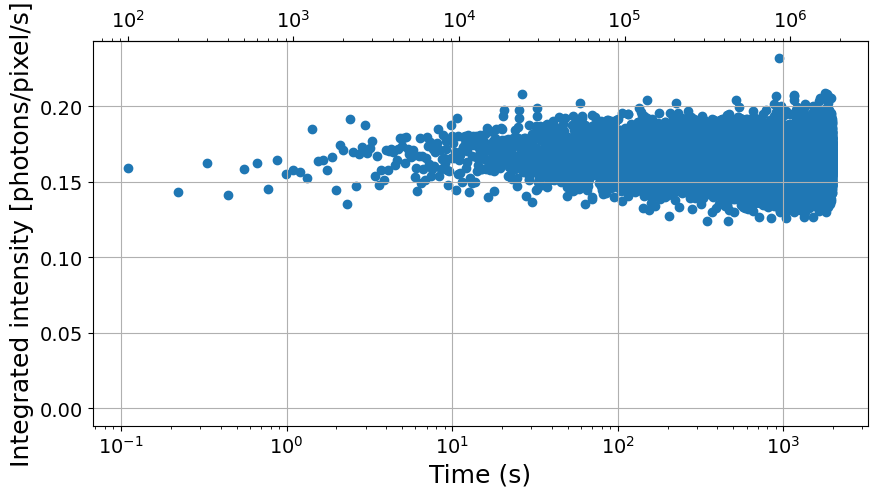

In [118]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [119]:
###################
Nfi = 100_000
Nff = None
Lbin = 1
Nbunch = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t_bybunch(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, Nbunch=Nbunch)

Computing G2t for bunch 1 (Nfi = 100000 , Nff = 117002 ) ...
Loading frames ...
Done! (elapsed time = 0.13 s)
	 | 17002 frames X 4471016 pixels
	 | sparsity = 1.71e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.109 GB
Masking data ...
Done! (elapsed time = 0.45 s)
	 | 17002 frames X 1404018 pixels
	 | sparsity = 1.84e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.037 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 1.12 s)
	 | 17002 X 17002 squared matrix
	 | memory usage (np.array @ float64) = 2.154 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.92 s)

Done!

Computing G2t for bunch 2 (Nfi = 117002 , Nff = 134004 ) ...
Loading frames ...
Done! (elapsed time = 0.08 s)
	 | 17002 frames X 4471016 pixels
	 | sparsity = 1.70e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.109 GB
Masking data ...
Done! (elapsed time = 0.4 s)
	 | 17002 frames X 1404018 pixels
	 | sparsity = 1.83e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.037 GB
Compu

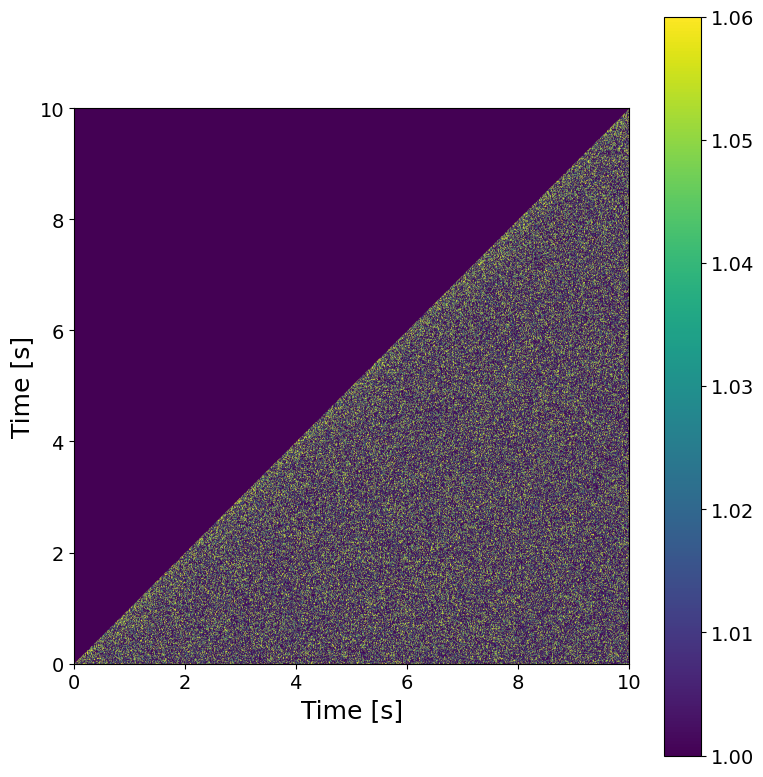

In [120]:
############################
t1, t2 = 0, 10
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

### g2(t)

In [121]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 0.49 s)



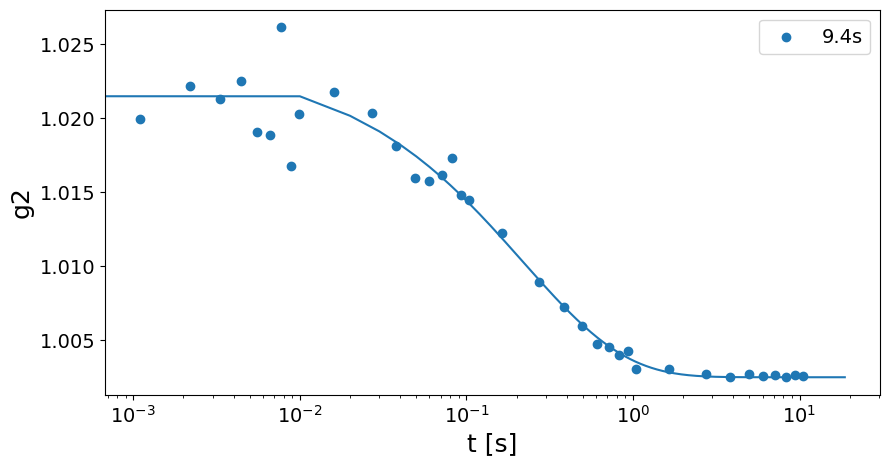

tau = 0.21731895797619163 +/- 0.06871635103882352
beta = 0.7046293587296015 +/- 0.14689456323252756
c = 0.021248260404926476 +/- 0.0037041892823897085
y0 = 1.0025172242425269 +/- 9.779727940322079e-05


In [122]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

fit_out.to_csv(fit_outs_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  

## XPCS mesh (T = 730C Q =  0.38 Å, 20 min @ 1ms (1_200_000 fm)) (GeO2_3, dataset 1, scan 6)

In [105]:
#######################################
sample_name = 'GeO2_3_730C_Q'
Ndataset = 1
Nscan = 6
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1200192
Ei = 9.699998837562536
itime = 0.0011
theta = 4.0
Q = 0.34
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/241 loops)
	 -> loading

### Qmask

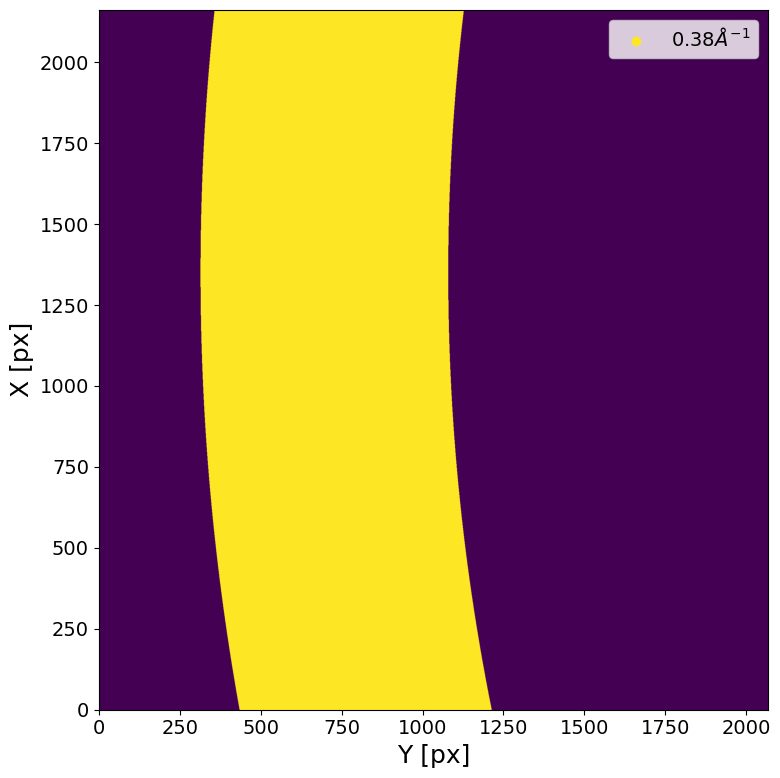

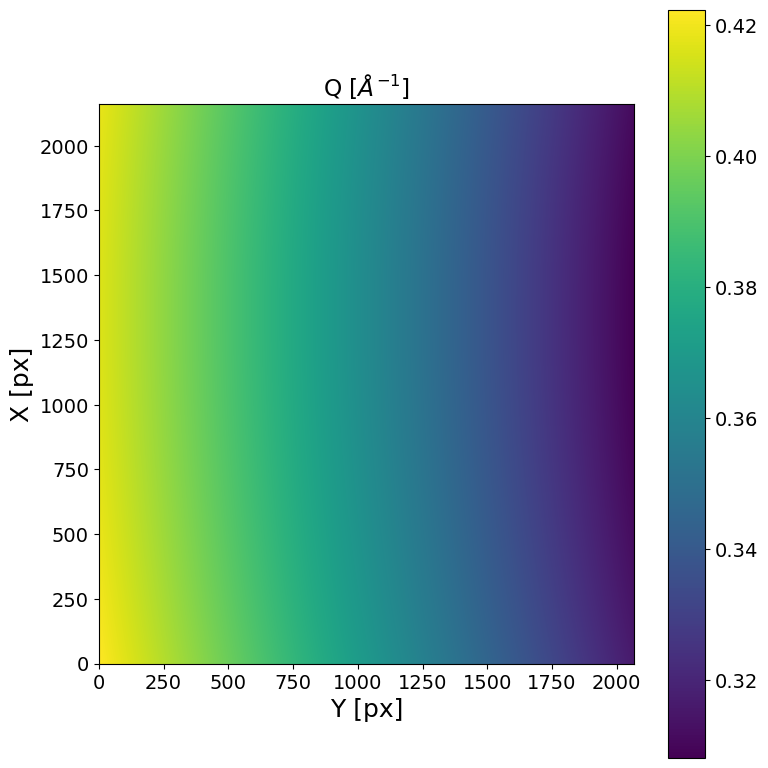

In [106]:
###################
Q    = .38
Qres = .02
###################

Qmask = XPCS.gen_Qmask(Ei, theta, Q, Qres, Qmap_plot=True)

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  836068 pixels (of 4471016 => 25.14 %)
################################################################################



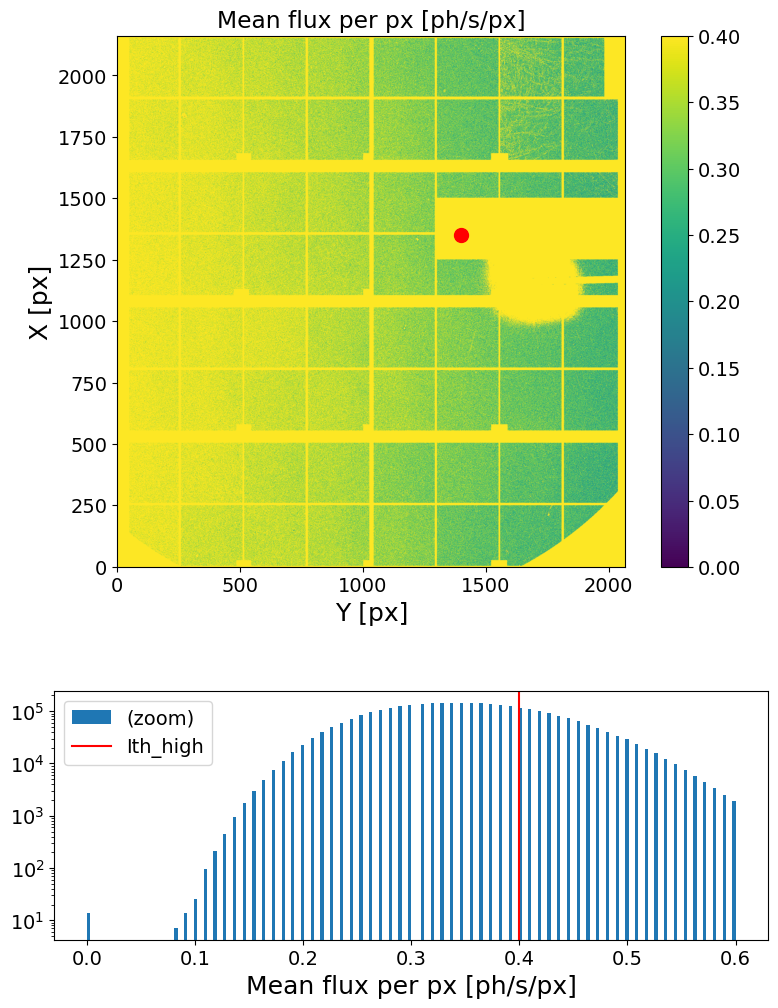

In [107]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .4, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [108]:
####################
Lbin = 1
Nstep = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

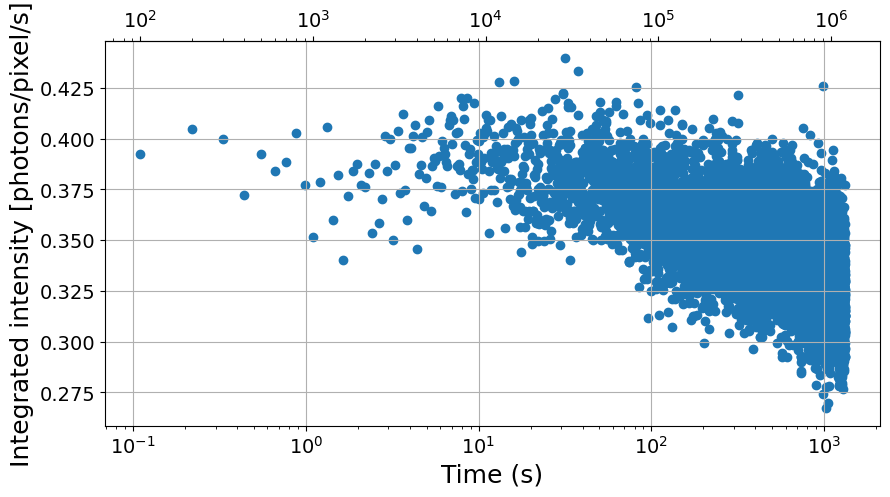

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [110]:
###################
Nfi = 100_000
Nff = None
Lbin = 1
Nbunch = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t_bybunch(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, Nbunch=Nbunch)

Computing G2t for bunch 1 (Nfi = 100000 , Nff = 111001 ) ...
Loading frames ...
Done! (elapsed time = 0.2 s)
	 | 11001 frames X 4471016 pixels
	 | sparsity = 3.42e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.141 GB
Masking data ...
Done! (elapsed time = 0.74 s)
	 | 11001 frames X 1402367 pixels
	 | sparsity = 3.98e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.052 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 0.4 s)
	 | 11001 X 11001 squared matrix
	 | memory usage (np.array @ float64) = 0.902 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.05 s)

Done!

Computing G2t for bunch 2 (Nfi = 111001 , Nff = 122002 ) ...
Loading frames ...
Done! (elapsed time = 0.21 s)
	 | 11001 frames X 4471016 pixels
	 | sparsity = 3.39e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.14 GB
Masking data ...
Done! (elapsed time = 0.63 s)
	 | 11001 frames X 1402367 pixels
	 | sparsity = 3.95e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.051 GB
Computi

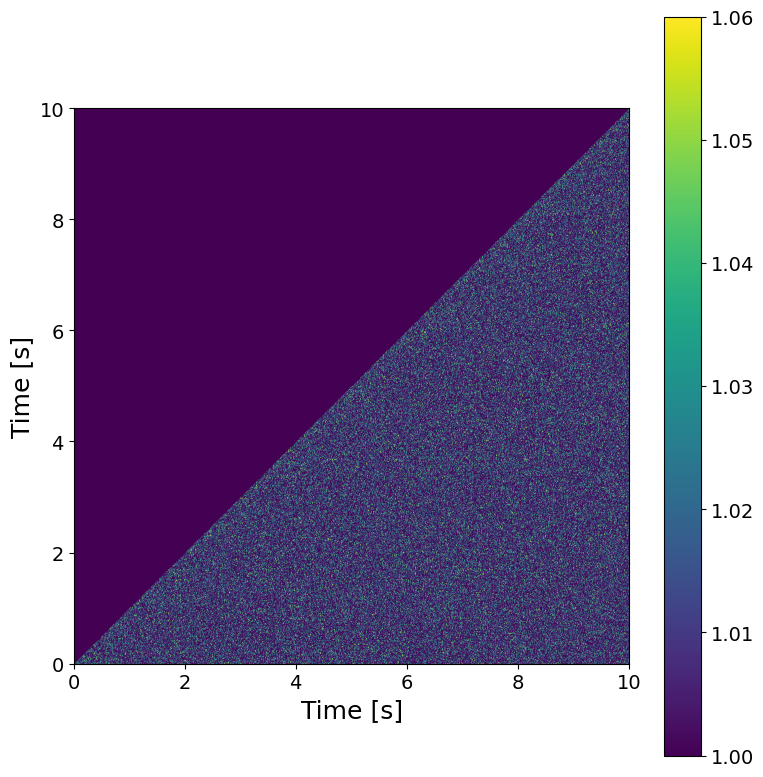

In [111]:
############################
t1, t2 = 0, 10
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

### g2(t)

In [112]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 0.42 s)



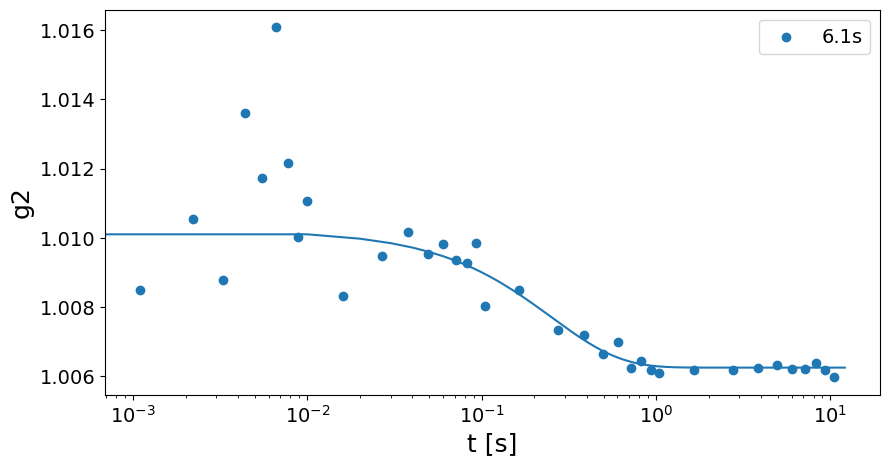

tau = 0.25072401272600964 +/- 0.11861587264470112
beta = 1.0960998908068509 +/- 0.6586157978490594
c = 0.003965244322021065 +/- 0.0013934570629277412
y0 = 1.0062535858690247 +/- 6.684160416315285e-05


In [113]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

fit_out.to_csv(fit_outs_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  

## XPCS mesh (T = 730C Q =  0.46 Å, 20 min @ 1ms (1_200_000 fm)) (GeO2_3, dataset 1, scan 7)

In [96]:
#######################################
sample_name = 'GeO2_3_730C_Q'
Ndataset = 1
Nscan = 7
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1200192
Ei = 9.699998837562536
itime = 0.0011
theta = 5.0
Q = 0.43
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/241 loops)
	 -> loading

### Qmask

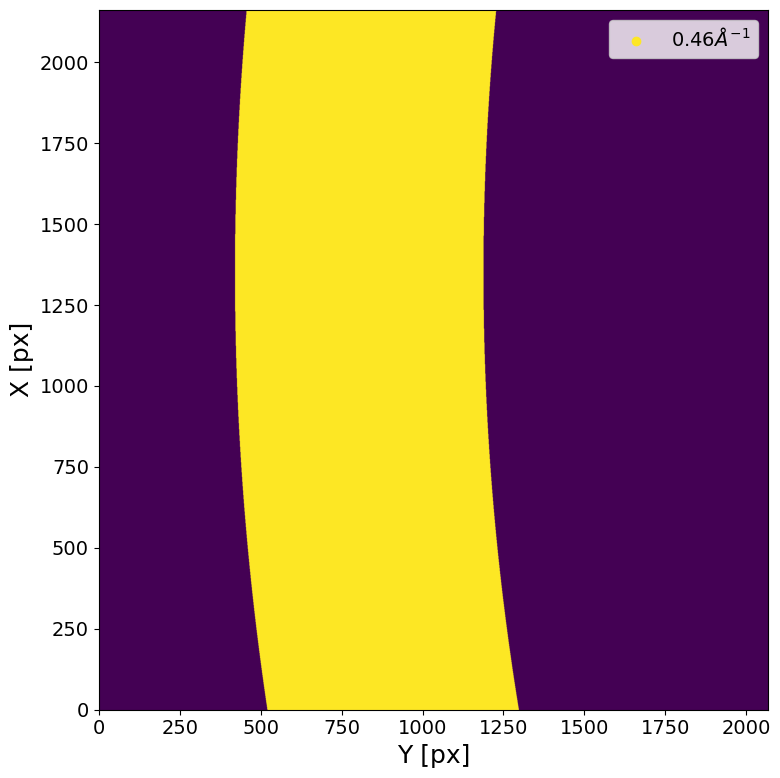

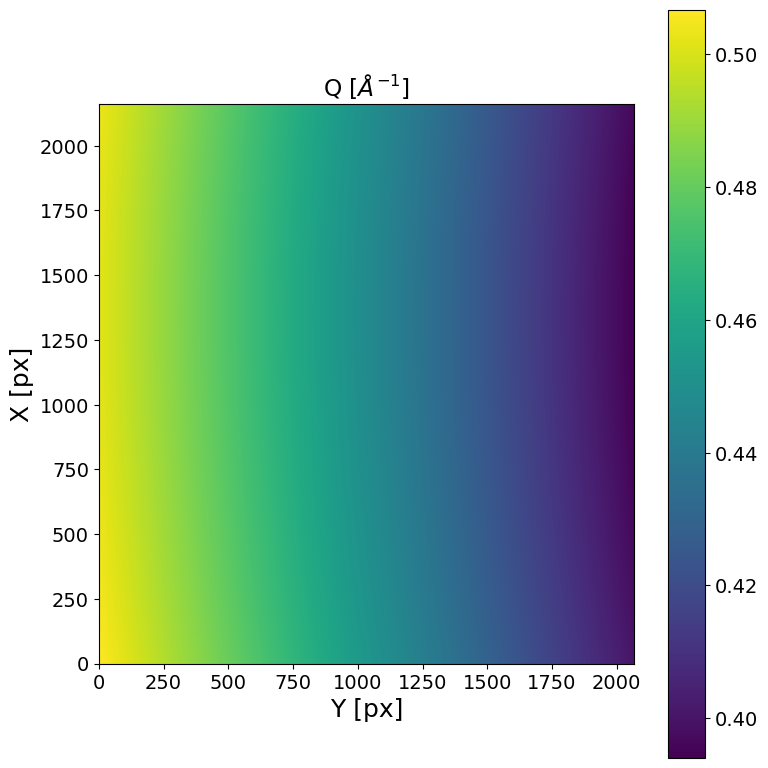

In [97]:
###################
Q    = .46
Qres = .02
###################

Qmask = XPCS.gen_Qmask(Ei, theta, Q, Qres, Qmap_plot=True)

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  808101 pixels (of 4471016 => 24.3 %)
################################################################################



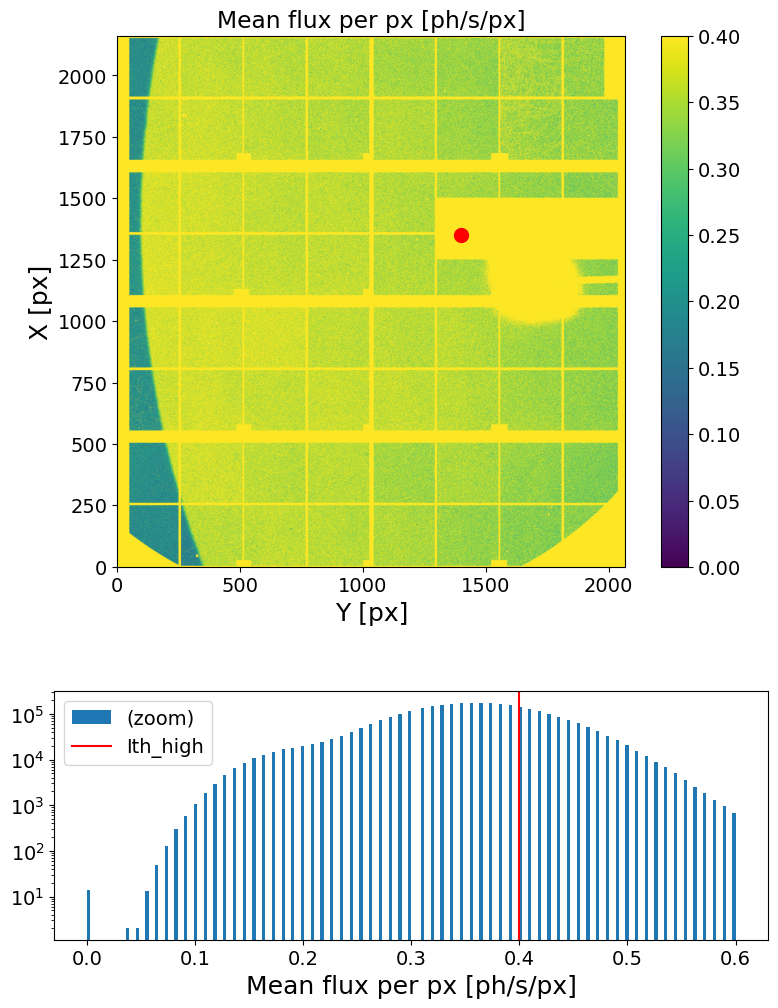

In [98]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .4, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [99]:
####################
Lbin = 1
Nstep = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

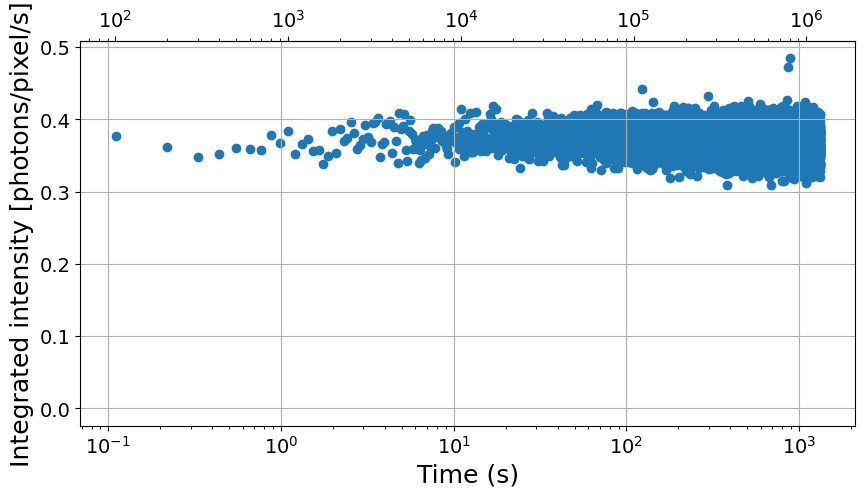

In [100]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [101]:
###################
Nfi = 100_000
Nff = None
Lbin = 10
Nbunch = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t_bybunch(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, Nbunch=Nbunch)

Computing G2t for bunch 1 (Nfi = 100000 , Nff = 111001 ) ...
Loading frames ...
Done! (elapsed time = 0.19 s)
Binning frames (Lbin = 10, using MKL library) ...
Done! (elapsed time = 0.42 s)
	 | 1100 frames X 4471016 pixels
	 | sparsity = 3.53e-03
	 | memory usage (sparse.csr_array @ float64) = 0.194 GB
Masking data ...
Done! (elapsed time = 0.39 s)
	 | 1100 frames X 1405396 pixels
	 | sparsity = 4.09e-03
	 | memory usage (sparse.csr_array @ float64) = 0.071 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 0.28 s)
	 | 1100 X 1100 squared matrix
	 | memory usage (np.array @ float64) = 0.009 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.01 s)

Done!

Computing G2t for bunch 2 (Nfi = 111001 , Nff = 122002 ) ...
Loading frames ...
Done! (elapsed time = 0.22 s)
Binning frames (Lbin = 10, using MKL library) ...
Done! (elapsed time = 0.4 s)
	 | 1100 frames X 4471016 pixels
	 | sparsity = 3.53e-03
	 | memory usage (sparse.csr_array @ float64) = 0.194 GB
Mask

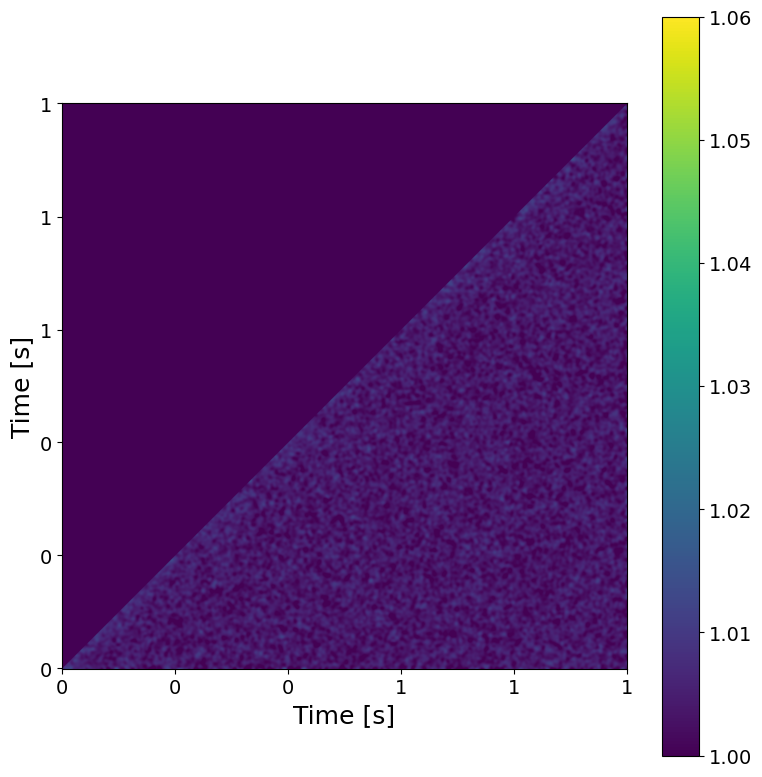

In [102]:
############################
t1, t2 = 0, 10
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

### g2(t)

In [103]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 0.01 s)



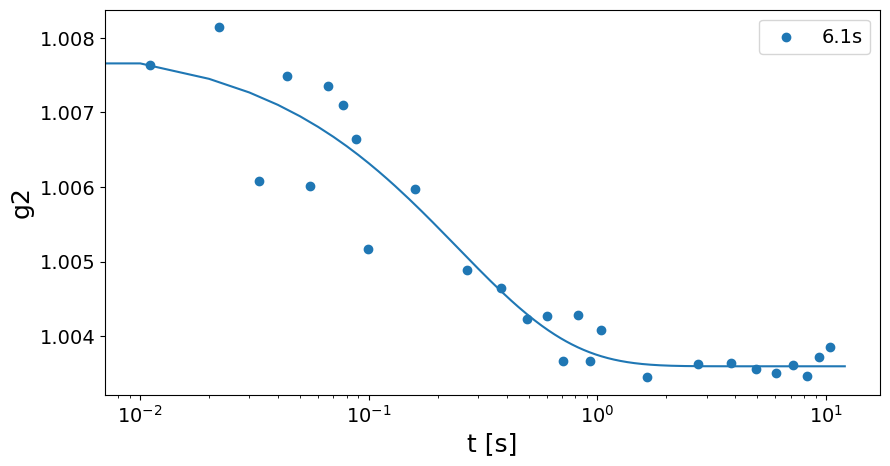

tau = 0.24402690179863976 +/- 0.1369221570896865
beta = 0.8592080229035906 +/- 0.42019322152597915
c = 0.0043290805291683965 +/- 0.001569462365215996
y0 = 1.0035978602484277 +/- 5.616554531898223e-05


In [104]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

fit_out.to_csv(fit_outs_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  